In [445]:
import numpy as np
import matplotlib.pyplot as plt

Consider solving the following initial-boundary value problem
$$  \frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}, \qquad (x,t) \in (0,L)\times(0,T]  $$
where the initial value is given by
$$  u(x,0) = I(x), \quad u(0,0)=u_0, \quad u(L,0) = u_L  $$


In [446]:
T = 20
L = 10
dx = 0.1
dt = 0.001
alpha = 1
F = alpha*dt/dx**2

xList = np.arange(0,L,dx)
tList = np.arange(0,T,dt)
N_x = xList.shape[0]
N_t = tList.shape[0]

u_0 = 0
u_L = 0

X,T = np.meshgrid(xList,tList)



In [470]:
def I(x):
    # sigma = 1
    # mean = L/2
    # return np.exp(-0.5*((x-mean)/sigma)**2)fd
    results = np.ones(x.shape)
    results[:4*N_x//10] = 0
    results[6*N_x//10:] = 0
    return results
    


def f(x,t):
    # mean = L / 2
    # sigma = L / 100
    # return np.exp(-0.5 * ((x - mean) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi)) * np.exp(-t/10)
    # return 10*alpha*t + 5*x*(L-x)
    return 0*x


def u(x,t):
    return 5*t*x*(L-x)


## Explicit Euler Method

In [448]:
computedList = np.zeros((xList.shape[0],tList.shape[0]))
computedList[:,0] = I(xList)
computedList[0,0] = u_0
computedList[-1,0] = u_L
for i in range(1,N_t):
    computedList[1:N_x-1,i] = computedList[1:N_x-1,i-1] \
    + alpha*dt/(dx)**2 * (computedList[2:N_x,i-1] - 2* computedList[1:N_x-1,i-1] + computedList[0:N_x-2,i-1]) \
    + f(xList[1:N_x-1],tList[i]) * dt

    computedList[0,i] = u_0
    computedList[-1,i] = u_L

    

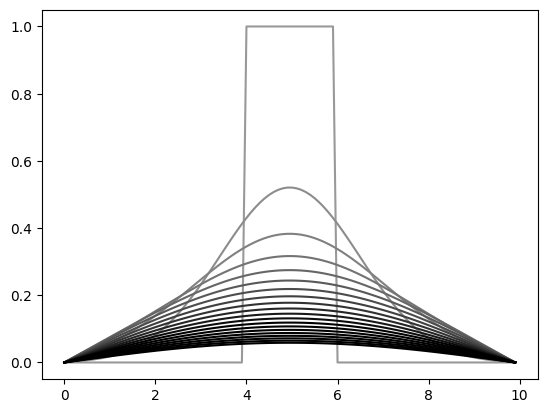

In [482]:
numberOfLines = 20
num_shades = numberOfLines
cmap = plt.get_cmap('gray')
colors = [cmap((i) / num_shades-0.35) for i in range(num_shades)]

for i in range(numberOfLines):
    plt.plot(xList,computedList[:,i*N_t//numberOfLines],color=colors[-i-1])
    


## Implicit Euler Method

In [466]:
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve


In [472]:
mainDiag = np.ones(N_x)*(1+2*F); mainDiag[0] = 1; mainDiag[-1] = 1
lowerDiag = np.ones(N_x-1)*(-F); lowerDiag[-1] = 0
upperDiag = np.ones(N_x-1)*(-F); upperDiag[0] = 0

diagonals = [lowerDiag, mainDiag, upperDiag]; offsets = [-1, 0, 1]
A = diags(diagonals, offsets).tocsc()

In [492]:
computedList = np.zeros((xList.shape[0],tList.shape[0]))
computedList[:,0] = I(xList)
computedList[0,0] = u_0
computedList[-1,0] = u_L
for i in range(1,N_t):
    F = f(xList,tList[i])*dt; F[-1]=0; F[0]=0
    b = computedList[:,i-1] + F
    computedList[:,i] = spsolve(A, b)


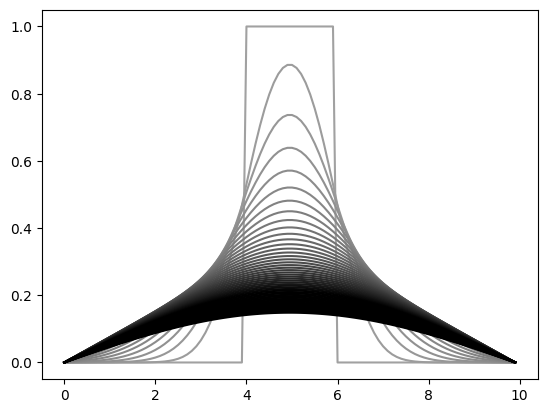

In [493]:
numberOfLines = 50
num_shades = numberOfLines
cmap = plt.get_cmap('gray')
colors = [cmap((i) / num_shades-0.35) for i in range(num_shades)]

for i in range(numberOfLines):
    plt.plot(xList,computedList[:,i*N_t//numberOfLines],color=colors[-i-1])
    


## Crank–Nicolson method
The approximated PDE is
$$  [D_t u = \alpha D_x D_x u + f]_i^{n+1/2}  $$
Which is a compact form of 
$$  \frac{u_i^{n+1/2} - u_i^{n-1/2}}{\Delta t} = \frac{\alpha}{\Delta x^2}(u_{i+1}^{n+1/2} - 2u_{i}^{n+1/2} + u_{i-1}^{n+1/2}) + f_i^{n+1/2} $$
By approximating the mid time step values by the average of neighbor time steps values, i.e. for instance $ u^{n+1/2} = 1/2(u^n + u^{n+1}) $ we will get
$$ u_{i}^{n+1} - \frac{F}{2}(u_{i+1}^{n+1} - 2u_i^n + u_{i-1}^{n_1}) = u_i^n  + \frac{F}{2}(u_{i+1}^n - 2u_{i}^n + u_{i-1}^n) + 1/2(f_i^n + f_i^{n+1})\Delta t $$



In [495]:
mainDiag = np.ones(N_x)*(1+F); mainDiag[0] = 1; mainDiag[-1] = 1
lowerDiag = np.ones(N_x-1)*(-F/2); lowerDiag[-1] = 0
upperDiag = np.ones(N_x-1)*(-F/2); upperDiag[0] = 0

diagonals = [lowerDiag, mainDiag, upperDiag]; offsets = [-1, 0, 1]
A = diags(diagonals, offsets).tocsc()

mainDiag = np.ones(N_x)*(1-F); mainDiag[0] = 1; mainDiag[-1] = 1
lowerDiag = np.ones(N_x-1)*(F/2); lowerDiag[-1] = 0
upperDiag = np.ones(N_x-1)*(F/2); upperDiag[0] = 0

diagonals = [lowerDiag, mainDiag, upperDiag]; offsets = [-1, 0, 1]
B = diags(diagonals, offsets).tocsc()

mainDiag = np.ones(N_x)*1/2
upperDiag = np.ones(N_x-1)*1/2; upperDiag[0] = 0

diagonals = [mainDiag, upperDiag]; offsets = [0, 1]
F = diags(diagonals, offsets).tocsc()

ValueError: operands could not be broadcast together with shapes (99,) (100,) 

In [485]:
computedList = np.zeros((xList.shape[0],tList.shape[0]))
computedList[:,0] = I(xList)
computedList[0,0] = u_0
computedList[-1,0] = u_L
for i in range(1,N_t):
    b = B.dot(computedList[:,i-1])
    computedList[:,i] = spsolve(A, b)

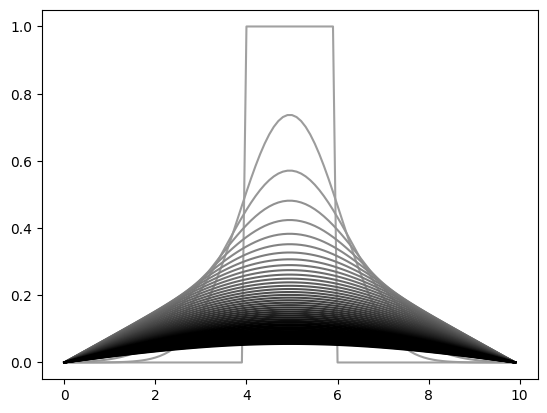

In [486]:
numberOfLines = 50
num_shades = numberOfLines
cmap = plt.get_cmap('gray')
colors = [cmap((i) / num_shades-0.35) for i in range(num_shades)]

for i in range(numberOfLines):
    plt.plot(xList,computedList[:,i*N_t//numberOfLines],color=colors[-i-1])
    
